# Задание 2


Многоклассовая классификация

1. Подготовить анализ и обработку датасета
2. Необходимо получить модель классификации (из упоминаемых в лекции), дающую одинаково высокое качество на разных классах датасета
3. Качество модели продемонстрировать с помощью посчитанных метрик
4. Выложить на github


## Анализ и обработка датасета

### Анализ датасета

Импортируем необходимые для дальнейшей работы библиотеки

In [67]:
%pip install pandas nltk seaborn matplotlib
!gdown 1y8v3DBhpkcy6nlyID7d5k0rjzv80Dyeo
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

Downloading...
From: https://drive.google.com/uc?id=1y8v3DBhpkcy6nlyID7d5k0rjzv80Dyeo
To: /content/dataset.xlsx
100% 11.3M/11.3M [00:00<00:00, 94.2MB/s]


In [68]:
df = pd.read_excel('dataset.xlsx')
df.head()

,oid,text,category
0,749208109,СПОЧНО СООБЩЕСТВО ПРОДАЕТСЯ ЗА 1300Р ЗА ПОКУПК...,esport
1,749208109,Пусть это побудет здесь БорьбаВпрямомЭфире How...,esport
2,749208109,Раздача пиздюлей от Мунсунга. HowToFtokenoid Б...,esport
3,749208109,Не знаю как вам но мне стилистика нравится пус...,esport
4,749208109,Скриншоты из новой главы. Тэхунчика показали и...,esport


Посмотрим на имеющиеся классы и описание колонки с ними

In [69]:
print(df.category.describe())
print(df.category.unique())

count         53198
unique           13
top       athletics
freq           4782
Name: category, dtype: object
['esport' 'martial_arts' 'tennis' 'basketball' 'volleyball' 'boardgames'
 'athletics' 'winter_sport' 'football' 'motosport' 'autosport' 'extreme'
 'hockey']


Удалим дубликаты, NaN и ресетнем индекс

In [70]:
df.dropna(inplace=True)
df.drop_duplicates(subset="text", inplace=True)
df.reset_index(inplace=True)
df.drop(columns=['index'], inplace=True)

Взглягем сколько данных исчезло

In [71]:
print(df.describe())

                oid
count  4.797300e+04
mean   5.073417e+08
std    2.849246e+08
min    1.659400e+04
25%    2.683148e+08
50%    5.132008e+08
75%    7.500718e+08
max    9.997113e+08


Выведем график количество объектов каждого класса и их процентное соотношение

,category,% of Count
category,,
tennis,4430,9.234361
winter_sport,4391,9.153065
volleyball,4299,8.961291
football,4161,8.673629
martial_arts,4032,8.404728
esport,3976,8.287995
athletics,3963,8.260897
motosport,3850,8.025348
basketball,3668,7.645968


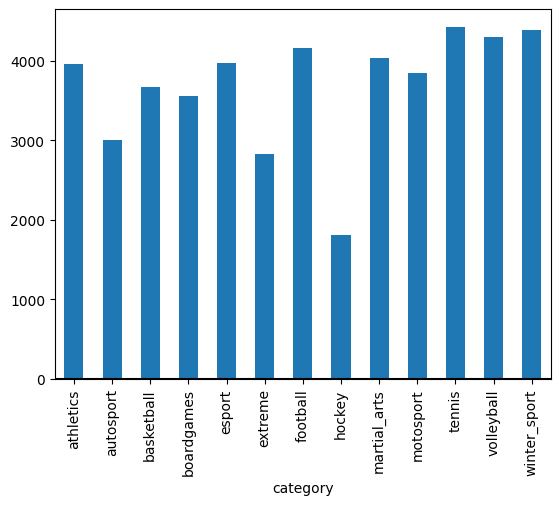

In [72]:
def count_table(df, c):
        count = df[c].value_counts()
        count_percent = 100 * count / len(df)
        count_table = pd.concat([count, count_percent], axis=1)

        count_table.columns = [c, '% of Count']
        count_table.round(2)

        gb = df.groupby(df[c])
        targetEDA=gb[c].aggregate(len)

        plt.figure()
        targetEDA.plot(kind='bar', grid=False)
        plt.axhline(0, color='k')

        return count_table

count_table(df, 'category')

### Очистка от лишних символов

Установим необходмимые модули

In [73]:
%pip install -U pymystem3 emoji

Импортируем библиотеки и напишем функцию, которая принимает колонку с "грязным" текстом, а возвращает уже колонку с чистым

In [74]:
import emoji
from pymystem3 import Mystem
import string
import nltk
from nltk.corpus import stopwords
def standartize_text(df):
    m = Mystem()

    nltk.download("stopwords")
    russian_stopwords = stopwords.words("russian")
    df = df.apply(emoji.demojize)
    df = df.replace(to_replace=":", value=" ")
    df = df.replace(to_replace="–", value=" ")
    df = df.replace(to_replace=r'[^\w\s]', value=" ", regex=True)
    df = df.replace(to_replace=r"(.)\1\1+", value=r'\1\1', regex=True)
    list_patterns = [r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', \
                    r'((?i)tokenoid)', r'((?i)token)', r'(\d+)']
    pattern = re.compile("|".join(list_patterns))
    df = df.replace(to_replace=pattern, value='', regex=True)
    df = df.str.lower().str.strip().str.translate(str.maketrans(dict.fromkeys(string.punctuation)))

    df = df.apply(lambda x: " ".join([word for word in m.lemmatize(x) if word not in russian_stopwords]))
    return df

Создадим колонку, в которой будет обрабатывать текст и очистим кэш pystem'а

In [75]:
!sudo rm -rf '/root/.local/bin/mystem'
df["cleaned_text"] = df['text'].copy()
df["cleaned_text"] = standartize_text(df["cleaned_text"])

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Мы заметили, что в датасете есть рекламне комментарии, то есть выбросы. Поищем их по ключевым словам и удалим

In [76]:
df.drop(index=df[df['cleaned_text'].apply(lambda x: (" продаваться " in x or " р " in x) and (" сообщество " in x or " паблик " in x))].index, inplace=True)
df.drop(index=df[df['cleaned_text'].str.contains('ссылка') & (df['category'] == 'extreme')].index, inplace=True)
df

,oid,text,category,cleaned_text
1,749208109,Пусть это побудет здесь БорьбаВпрямомЭфире How...,esport,пусть это побыть борьбавпрямомэфир h...
2,749208109,Раздача пиздюлей от Мунсунга. HowToFtokenoid Б...,esport,раздача пиздюли мунсунг howtof борь...
3,749208109,Не знаю как вам но мне стилистика нравится пус...,esport,знать стилистика нравиться пус...
4,749208109,Скриншоты из новой главы. Тэхунчика показали и...,esport,скриншот новый глава тэхунчик показ...
5,749208109,Зато они все вместе. . HowToFtokenoid БорьбаВП...,esport,зато весь вместе howtof борьбавпрям...
...,...,...,...,...
47968,910636962,8 битная буря снова накрыла пикселями автомоби...,autosport,битный буря снова накрывать пиксел а...
47969,669736851,Ира Сидоркова объясняет как сказалась на ее ма...,autosport,ира сидорков объяснять сказываться ...
47970,558919241,24 я ракетка мира хорват Марин Чилич обыграл и...,tennis,ракетка мир хорват марина чилич об...
47971,776944963,Стал известен календарь мужской сборной России...,volleyball,становиться известный календарь мужской ...


Удалим образовавшиеся дубликаты и ненужные столбцы

In [77]:
df.dropna(inplace=True)
df.drop_duplicates(subset="text", inplace=True)
df.reset_index(inplace=True)
df.drop(columns=['index', 'text', 'oid'], inplace=True)
df

,category,cleaned_text
0,esport,пусть это побыть борьбавпрямомэфир h...
1,esport,раздача пиздюли мунсунг howtof борь...
2,esport,знать стилистика нравиться пус...
3,esport,скриншот новый глава тэхунчик показ...
4,esport,зато весь вместе howtof борьбавпрям...
...,...,...
47800,autosport,битный буря снова накрывать пиксел а...
47801,autosport,ира сидорков объяснять сказываться ...
47802,tennis,ракетка мир хорват марина чилич об...
47803,volleyball,становиться известный календарь мужской ...


Сохраним новый чистй датасет

In [78]:
df = df[["cleaned_text","category"]]
df.to_excel("clean.xlsx")

## Пробуем различные модели

Здесь мы будем пробовать различные baseline на дефолтных настройках, чтобы поискать подходящую нам, а также готовить векторы для них

### Подготовка, разделение данных и векторизация данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold,  train_test_split
%pip install mlxtend
from mlxtend.feature_selection import ColumnSelector

In [ ]:
df = pd.read_excel("clean.xlsx", index_col=0)

In [ ]:
le = LabelEncoder()
df["class"] = le.fit_transform(df["category"])
df.drop(columns=["category"], inplace=True)
labels = le.classes_

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['class']), df['class'], stratify=df['class'], test_size=0.2,  random_state=42)

In [36]:
%pip install sentence_transformers
from sentence_transformers import SentenceTransformer, util

embedding_model = SentenceTransformer('DeepPavlov/rubert-base-cased')

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [37]:
embeddings_train = embedding_model.encode(np.array(X_train["cleaned_text"]))
embeddings_test = embedding_model.encode(np.array(X_test["cleaned_text"]))


In [38]:
def plot_roc_curve(test_features, predict_prob):
    fpr, tpr, thresholds = roc_curve(test_features, predict_prob, pos_label=1)
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('ROC curve for toxic comments')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.legend(labels)
    plt.show()

def run_pipeline(pipeline, train_feats, train_lbls, test_feats, test_lbls, labels):
    pipeline.fit(train_feats, train_lbls)
    predictions = pipeline.predict(test_feats)
    pred_proba = pipeline.predict_proba(test_feats)
    print('roc_auc: ', roc_auc_score(test_lbls, pred_proba, multi_class="ovr"))
    print('accuracy: ', accuracy_score(test_lbls, predictions))
    print('confusion matrices: ')
    cm = confusion_matrix(test_lbls, predictions)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)
    cm_display.plot()
    plt.show()
    print('classification_report: ')
    print(classification_report(test_lbls, predictions, target_names=labels))
    # plot_roc_curve(test_feats, pred_proba)

### Классические подходы

#### Naive Bayes



/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


roc_auc:  0.9857267382700322
accuracy:  0.8539864512767066
confusion matrices: 


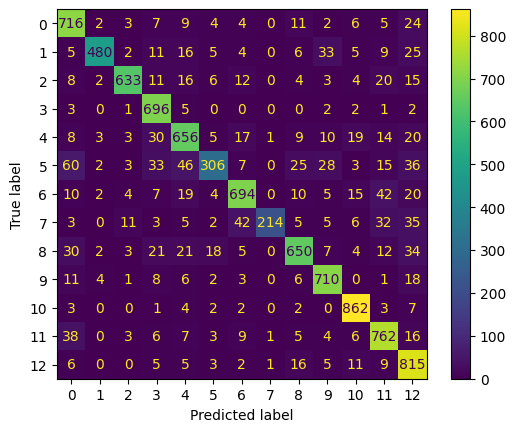

classification_report: 
              precision    recall  f1-score   support

   athletics       0.79      0.90      0.85       793
   autosport       0.97      0.80      0.87       601
  basketball       0.95      0.86      0.90       734
  boardgames       0.83      0.98      0.90       712
      esport       0.80      0.83      0.81       795
     extreme       0.85      0.54      0.66       564
    football       0.87      0.83      0.85       832
      hockey       0.99      0.59      0.74       363
martial_arts       0.87      0.81      0.84       807
   motosport       0.87      0.92      0.90       770
      tennis       0.91      0.97      0.94       886
  volleyball       0.82      0.89      0.85       860
winter_sport       0.76      0.93      0.84       878

    accuracy                           0.85      9595
   macro avg       0.87      0.83      0.84      9595
weighted avg       0.86      0.85      0.85      9595



In [39]:
NB_pipeline = Pipeline([('col_selector', ColumnSelector(cols=('cleaned_text'),drop_axis=True)),
                        ('tfidf', TfidfVectorizer()),
                        ('nb_model', OneVsRestClassifier(MultinomialNB(), n_jobs=-1))])

run_pipeline(NB_pipeline, X_train, y_train, X_test, y_test, labels)

roc_auc:  0.8792334348978146
accuracy:  0.5233976029181866
confusion matrices: 


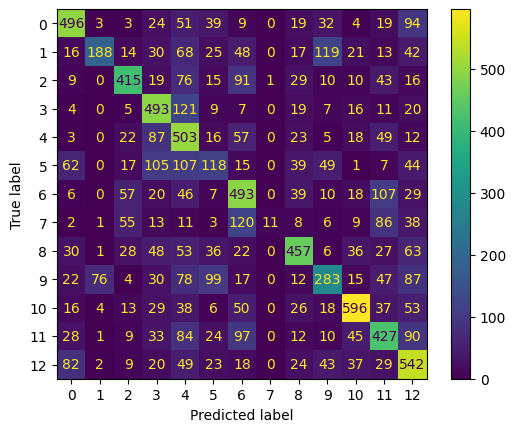

classification_report: 
              precision    recall  f1-score   support

   athletics       0.64      0.63      0.63       793
   autosport       0.68      0.31      0.43       601
  basketball       0.64      0.57      0.60       734
  boardgames       0.52      0.69      0.59       712
      esport       0.39      0.63      0.48       795
     extreme       0.28      0.21      0.24       564
    football       0.47      0.59      0.53       832
      hockey       0.92      0.03      0.06       363
martial_arts       0.63      0.57      0.60       807
   motosport       0.47      0.37      0.41       770
      tennis       0.72      0.67      0.70       886
  volleyball       0.47      0.50      0.48       860
winter_sport       0.48      0.62      0.54       878

    accuracy                           0.52      9595
   macro avg       0.56      0.49      0.48      9595
weighted avg       0.55      0.52      0.51      9595



In [40]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', MultinomialNB()),
])

run_pipeline(clf, embeddings_train, y_train, embeddings_test, y_test, labels)

#### Logistic regresssion

roc_auc:  0.9839513369039028
accuracy:  0.8648254299114122
confusion matrices: 


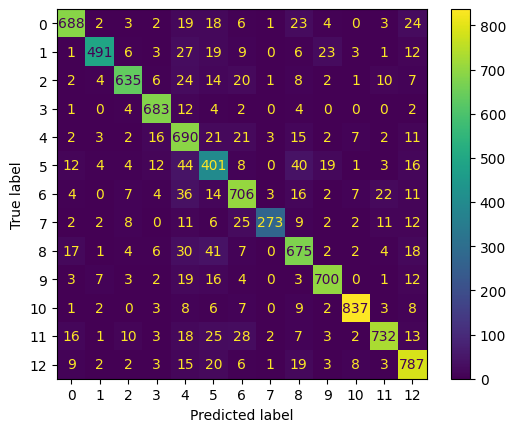

classification_report: 
              precision    recall  f1-score   support

   athletics       0.91      0.87      0.89       793
   autosport       0.95      0.82      0.88       601
  basketball       0.92      0.87      0.89       734
  boardgames       0.92      0.96      0.94       712
      esport       0.72      0.87      0.79       795
     extreme       0.66      0.71      0.69       564
    football       0.83      0.85      0.84       832
      hockey       0.96      0.75      0.84       363
martial_arts       0.81      0.84      0.82       807
   motosport       0.92      0.91      0.91       770
      tennis       0.96      0.94      0.95       886
  volleyball       0.92      0.85      0.88       860
winter_sport       0.84      0.90      0.87       878

    accuracy                           0.86      9595
   macro avg       0.87      0.86      0.86      9595
weighted avg       0.87      0.86      0.87      9595



In [41]:
LR_pipeline = Pipeline([('col_selector', ColumnSelector(cols=('cleaned_text'),drop_axis=True)),
                        ('tfidf', TfidfVectorizer()),
                        ('lr_model', OneVsRestClassifier(LogisticRegression(), n_jobs=-1))])
run_pipeline(LR_pipeline, X_train, y_train, X_test, y_test, labels)

Logistic regresssion with embeddings

roc_auc:  0.9485472411548017
accuracy:  0.7334028139656071
confusion matrices: 


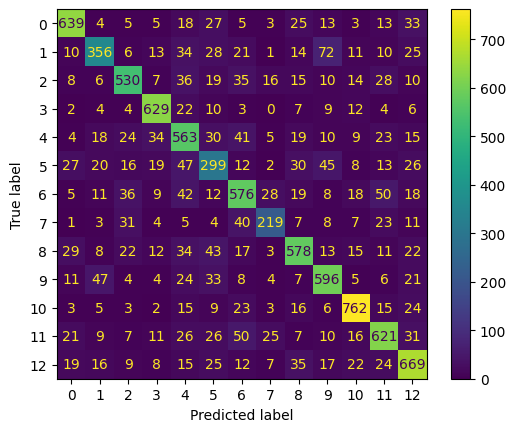

classification_report: 
              precision    recall  f1-score   support

   athletics       0.82      0.81      0.81       793
   autosport       0.70      0.59      0.64       601
  basketball       0.76      0.72      0.74       734
  boardgames       0.83      0.88      0.86       712
      esport       0.64      0.71      0.67       795
     extreme       0.53      0.53      0.53       564
    football       0.68      0.69      0.69       832
      hockey       0.69      0.60      0.65       363
martial_arts       0.74      0.72      0.73       807
   motosport       0.73      0.77      0.75       770
      tennis       0.84      0.86      0.85       886
  volleyball       0.74      0.72      0.73       860
winter_sport       0.73      0.76      0.75       878

    accuracy                           0.73      9595
   macro avg       0.73      0.72      0.72      9595
weighted avg       0.73      0.73      0.73      9595



In [42]:
run_pipeline(OneVsRestClassifier(LogisticRegression(), n_jobs=-1),\
             embeddings_train, y_train, embeddings_test, y_test, labels)

### Нейронные модели

In [ ]:
#TODO
#LSTM

### Деревья

#### RandomForest Classifier

roc_auc:  0.9748598911638431
accuracy:  0.8302240750390829
confusion matrices: 


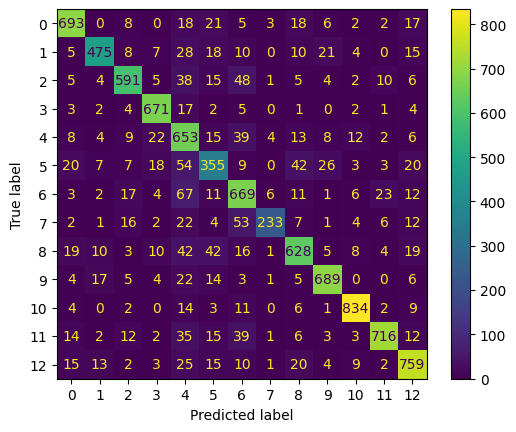

classification_report: 
              precision    recall  f1-score   support

   athletics       0.87      0.87      0.87       793
   autosport       0.88      0.79      0.83       601
  basketball       0.86      0.81      0.83       734
  boardgames       0.90      0.94      0.92       712
      esport       0.63      0.82      0.71       795
     extreme       0.67      0.63      0.65       564
    football       0.73      0.80      0.77       832
      hockey       0.93      0.64      0.76       363
martial_arts       0.81      0.78      0.80       807
   motosport       0.90      0.89      0.90       770
      tennis       0.94      0.94      0.94       886
  volleyball       0.93      0.83      0.88       860
winter_sport       0.85      0.86      0.86       878

    accuracy                           0.83      9595
   macro avg       0.84      0.82      0.82      9595
weighted avg       0.84      0.83      0.83      9595



In [ ]:
from sklearn.ensemble import RandomForestClassifier

RF_pipeline = Pipeline([('col_selector', ColumnSelector(cols=('cleaned_text'),drop_axis=True)),
                        ('tfidf', TfidfVectorizer()),
                        ('rf_model', RandomForestClassifier(n_estimators=100))])
run_pipeline(RF_pipeline, X_train, y_train, X_test, y_test, labels)

roc_auc:  0.9126663221398512
accuracy:  0.6361646690984888
confusion matrices: 


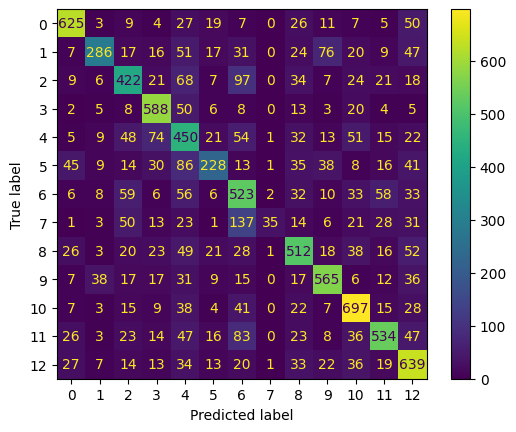

classification_report: 
              precision    recall  f1-score   support

   athletics       0.79      0.79      0.79       793
   autosport       0.75      0.48      0.58       601
  basketball       0.59      0.57      0.58       734
  boardgames       0.71      0.83      0.76       712
      esport       0.45      0.57      0.50       795
     extreme       0.62      0.40      0.49       564
    football       0.49      0.63      0.55       832
      hockey       0.85      0.10      0.17       363
martial_arts       0.63      0.63      0.63       807
   motosport       0.72      0.73      0.73       770
      tennis       0.70      0.79      0.74       886
  volleyball       0.71      0.62      0.66       860
winter_sport       0.61      0.73      0.66       878

    accuracy                           0.64      9595
   macro avg       0.66      0.60      0.60      9595
weighted avg       0.65      0.64      0.63      9595



In [ ]:
run_pipeline(RandomForestClassifier(n_estimators=100), embeddings_train, y_train, embeddings_test, y_test, labels)

### Трансформеры

In [ ]:
%pip install simpletransformers
from simpletransformers.classification import ClassificationModel


usage: gdown [-h] [-V] [-O OUTPUT] [-q] [--fuzzy] [--id] [--proxy PROXY] [--speed SPEED]
             [--no-cookies] [--no-check-certificate] [--continue] [--folder] [--remaining-ok]
             [--format FORMAT] [--user-agent USER_AGENT]
             url_or_id
gdown: error: the following arguments are required: url_or_id


In [ ]:
bert_df = df
bert_df = bert_df.rename(columns={"cleaned_text":"text", "class":"labels"})
bert_df = bert_df[['text', 'labels']]
bert_df

,text,labels
0,пусть это побыть борьбавпрямомэфир h...,4
1,раздача пиздюли мунсунг howtof борьб...,4
2,знать стилистика нравиться пус...,4
3,скриншот новый глава тэхунчик показы...,4
4,зато весь вместе howtof борьбавпрям...,4
...,...,...
47967,битный буря снова накрывать пиксел а...,1
47968,ира сидорков объяснять сказываться ...,1
47969,ракетка мир хорват марина чилич об...,10
47970,становиться известный календарь мужской ...,11


In [ ]:
train, test = train_test_split(bert_df, stratify=bert_df['labels'], test_size=0.2,  random_state=42)

In [24]:

# define hyperparameter
train_args ={"reprocess_input_data": True,
             "fp16":False,
             "num_train_epochs": 4,
             "overwrite_output_dir": True}

# Create a ClassificationModel
model = ClassificationModel(
    "bert", "ai-forever/ruBert-base",
    num_labels=13,
    args=train_args
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
model.train_model(train)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/76 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/4798 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/4798 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/4798 [00:00<?, ?it/s]

Running Epoch 4 of 4:   0%|          | 0/4798 [00:00<?, ?it/s]

(19192, 0.4401104510269525)

In [35]:
import sklearn
result, model_outputs, wrong_predictions = model.eval_model(test)

lst = []
for arr in model_outputs:
    lst.append(np.argmax(arr))
true = test['labels'].tolist()
predicted = lst
sklearn.metrics.accuracy_score(true,predicted)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/19 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/96 [00:00<?, ?it/s]

0.8823345492443981

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
model.model.save_pretrained('drive/MyDrive/model1')
model.tokenizer.save_pretrained('drive/MyDrive/model1')
model.config.save_pretrained('drive/MyDrive/model1/')

## Испробовав разные модели я остановился на baseline TFIDF + LogRes. Данная комбинация дала наилучший результат без доп. улучшений(не считая трансформера, он показал себя лучше)

## Улучшение выбранного baseline

Проведем улуччшение выбранной модели

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold,  train_test_split
%pip install mlxtend
from mlxtend.feature_selection import ColumnSelector

In [80]:
df = pd.read_excel("clean.xlsx", index_col=0)


In [81]:

le = LabelEncoder()
df["class"] = le.fit_transform(df["category"])
df.drop(columns=["category"], inplace=True)
labels = le.classes_

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['class']), df['class'], stratify=df['class'], test_size=0.2,  random_state=42)

In [82]:
def plot_roc_curve(test_features, predict_prob):
    fpr, tpr, thresholds = roc_curve(test_features, predict_prob, pos_label=1)
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('ROC curve for toxic comments')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.legend(labels)
    plt.show()

def run_pipeline(pipeline, train_feats, train_lbls, test_feats, test_lbls, labels):
    pipeline.fit(train_feats, train_lbls)
    predictions = pipeline.predict(test_feats)
    pred_proba = pipeline.predict_proba(test_feats)
    print('roc_auc: ', roc_auc_score(test_lbls, pred_proba, multi_class="ovr"))
    print('accuracy: ', accuracy_score(test_lbls, predictions))
    print('confusion matrices: ')
    cm = confusion_matrix(test_lbls, predictions)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)
    cm_display.plot()
    plt.show()
    print('classification_report: ')
    print(classification_report(test_lbls, predictions, target_names=labels))
    # plot_roc_curve(test_feats, pred_proba)

Для баланса классов воспольщуемся библиотекой, которая поможет регулировать веса и значимость менее представленных классов

In [83]:
from sklearn.utils.class_weight import compute_class_weight

# Получение весов классов
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

Базовый пайплайн с весами для классов уже дал результатё

roc_auc:  0.9846503450859403
accuracy:  0.8674824809120385
confusion matrices: 


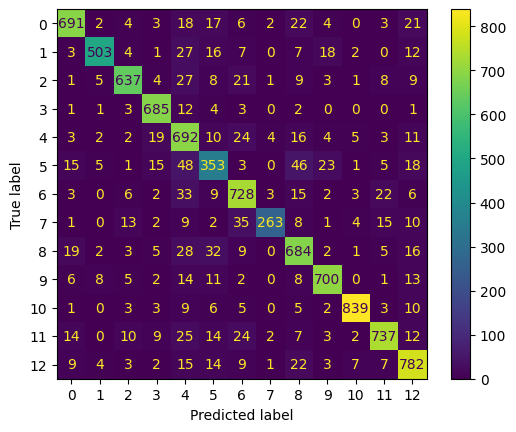

classification_report: 
              precision    recall  f1-score   support

   athletics       0.90      0.87      0.89       793
   autosport       0.95      0.84      0.89       600
  basketball       0.92      0.87      0.89       734
  boardgames       0.91      0.96      0.94       712
      esport       0.72      0.87      0.79       795
     extreme       0.71      0.66      0.69       533
    football       0.83      0.88      0.85       832
      hockey       0.95      0.72      0.82       363
martial_arts       0.80      0.85      0.83       806
   motosport       0.92      0.91      0.91       770
      tennis       0.97      0.95      0.96       886
  volleyball       0.91      0.86      0.88       859
winter_sport       0.85      0.89      0.87       878

    accuracy                           0.87      9561
   macro avg       0.87      0.86      0.86      9561
weighted avg       0.87      0.87      0.87      9561



In [84]:

LR_pipeline = Pipeline([('col_selector', ColumnSelector(cols=('cleaned_text'),drop_axis=True)),
                        ('tfidf', TfidfVectorizer()),
                        ('lr_model', OneVsRestClassifier(LogisticRegression(class_weight=dict(enumerate(class_weights))), n_jobs=-1))])
run_pipeline(LR_pipeline, X_train, y_train, X_test, y_test, labels)

Попробуем теперь перебрать гиперпараметры по сетке, а также провести кросс-валидацию

[Pipeline] ...... (step 1 of 3) Processing col_selector, total=   0.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   9.0s
[Pipeline] .......... (step 3 of 3) Processing lr_model, total=12.5min
roc_auc:  0.9840138121680607
accuracy:  0.8749084823763205
confusion matrices: 


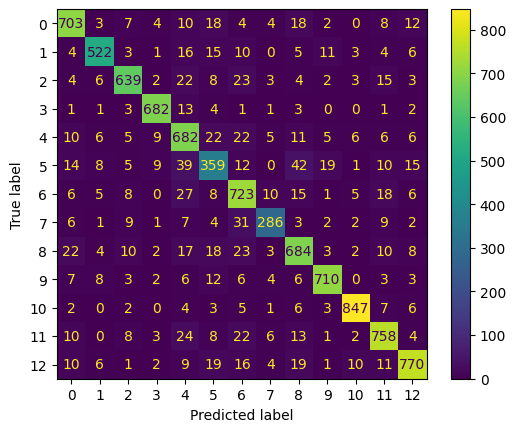

classification_report: 
              precision    recall  f1-score   support

   athletics       0.88      0.89      0.88       793
   autosport       0.92      0.87      0.89       600
  basketball       0.91      0.87      0.89       734
  boardgames       0.95      0.96      0.95       712
      esport       0.78      0.86      0.82       795
     extreme       0.72      0.67      0.70       533
    football       0.81      0.87      0.84       832
      hockey       0.87      0.79      0.83       363
martial_arts       0.83      0.85      0.84       806
   motosport       0.93      0.92      0.93       770
      tennis       0.96      0.96      0.96       886
  volleyball       0.88      0.88      0.88       859
winter_sport       0.91      0.88      0.89       878

    accuracy                           0.87      9561
   macro avg       0.87      0.87      0.87      9561
weighted avg       0.88      0.87      0.88      9561



In [85]:
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
logreg = LogisticRegression(class_weight=dict(enumerate(class_weights)))

parameters = [{'penalty':['l1','l2','elasticnet']},
              {'C':[1, 10, 100, 1000]}]
grid_search = GridSearchCV(estimator = logreg,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=3)


LR_pipeline = Pipeline([('col_selector', ColumnSelector(cols=('cleaned_text'),drop_axis=True)),
                        ('tfidf', TfidfVectorizer()),
                        ('lr_model', OneVsRestClassifier(grid_search, n_jobs=-1))], verbose=True)




run_pipeline(LR_pipeline, X_train, y_train, X_test, y_test, labels)

##Окончательный результаты метрики accuracy, которых удалось добиться - 0.875 для выбранного baseline. А также 0.882 для трансформера Rubert-base

Класс extreme явно плохо представлен и выдает очень плохие precision и recall. Возможно стоит oversampl'ить его или очистка датасета от рекламы в этом классе может помочь повысить score(реально помогает - проверено, его precision вырос на 0.05)